In [17]:
!pip install transformers datasets evaluate scikit-learn torch peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [18]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Prep
[Kaggle Data Link](https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset/data)

Dataset contains more than 28,000 essay written by student and AI generated.

Features :

* text: Which contains essay text
* generated/label: This is target label . 0 - Human Written Essay , 1 - AI Generated Essay

In [4]:
# Download the dataset to the data directory
path = kagglehub.dataset_download("sunilthite/llm-detect-ai-generated-text-dataset")

100%|██████████| 18.6M/18.6M [00:02<00:00, 9.53MB/s]

Extracting files...


In [8]:
print("Downloaded to:", path)
print(os.listdir(path))

Downloaded to: /root/.cache/kagglehub/datasets/sunilthite/llm-detect-ai-generated-text-dataset/versions/1
['Training_Essay_Data.csv']


In [9]:
df = pd.read_csv(os.path.join(path, "Training_Essay_Data.csv"))
df.head()

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


In [14]:
df = df.rename(columns={'generated': 'label'})
print(f"Dataset shape: {df.shape}")
print(f"Column names: {df.columns.tolist()}")
print(f"Label distribution: {df['label'].value_counts()}")

Dataset shape: (29145, 2)
Column names: ['text', 'label']
Label distribution: label
0    17508
1    11637
Name: count, dtype: int64


In [21]:
# Split the data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

In [22]:
print(f"Train set: {train_df.shape[0]} samples")
print(f"Validation set: {val_df.shape[0]} samples")
print(f"Test set: {test_df.shape[0]} samples")

Train set: 20401 samples
Validation set: 4372 samples
Test set: 4372 samples


In [23]:
print(f"Label distribution: {train_df['label'].value_counts()}")
print(f"Label distribution: {val_df['label'].value_counts()}")
print(f"Label distribution: {test_df['label'].value_counts()}")

Label distribution: label
0    12255
1     8146
Name: count, dtype: int64
Label distribution: label
0    2626
1    1746
Name: count, dtype: int64
Label distribution: label
0    2627
1    1745
Name: count, dtype: int64


In [24]:
# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

## Model Init

This code sets up a RoBERTa model with Parameter-Efficient Fine-Tuning (PEFT) using the LoRA technique

Loading the base model and tokenizer:
* Initializing the RoBERTa model with a classification head configured for:
  * Binary classification (`num_labels=2` for human/AI text)
  * Single-label classification (each input has exactly one label)

In [25]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import get_peft_model, LoraConfig, TaskType

model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    problem_type="single_label_classification"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Configuring LoRA (Low-Rank Adaptation) for the model:
* `task_type=TaskType.SEQ_CLS`: This tells the model that we're performing sequence classification (categorizing entire text sequences).
  *  We're classifying whole text passages as either human-written (0) or AI-generated (1). This setting ensures that the model outputs the right format and that the loss function is appropriate for classification rather than other tasks like token prediction or regression.
* `r=8` (Rank): Sets the rank of the low-rank matrices to 8 (smaller values = fewer parameters).
* `lora_alpha=32` (Scaling Factor)
* `lora_dropout=0.1`: Adds 10% dropout to prevent overfitting in the LoRA layers


In [26]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    # Apply LoRA to attention layers of RoBERTa
    target_modules=["query", "key", "value"]
)

# This wraps the base RoBERTa model with the LoRA configuration
model = get_peft_model(base_model, peft_config)

In [27]:
# Print trainable parameters info
def print_trainable_parameters(model):
    trainable_params = 0
    all_params = 0
    for _, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable params: {trainable_params:,d} ({100 * trainable_params / all_params:.2f}%)")
    print(f"All params: {all_params:,d}")

print_trainable_parameters(model)

Trainable params: 1,034,498 (0.82%)
All params: 125,681,668


## Training Setup
Tokenization and Preprocessing:

In [28]:
# Tokenize the datasets
def preprocess(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512,
    )

# Apply preprocessing
tokenized_train = train_dataset.map(preprocess, batched=True)
tokenized_val = val_dataset.map(preprocess, batched=True)
tokenized_test = test_dataset.map(preprocess, batched=True)

Map:   0%|          | 0/20401 [00:00<?, ? examples/s]

Map:   0%|          | 0/4372 [00:00<?, ? examples/s]

Map:   0%|          | 0/4372 [00:00<?, ? examples/s]

In [29]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import torch

In [52]:
import wandb
wandb.init(mode="disabled")

In [60]:
# Configure training arguments
training_args = TrainingArguments(
    output_dir="./results/roberta-ai-detector",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=100,
    seed=42,
    fp16=torch.cuda.is_available(),  # Use mixed precision if available
    report_to=[]
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [61]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
)

<ipython-input-61-fe0971cb54e5>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


## Fine-tuning

In [62]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
3.615 GB of memory reserved.


In [63]:
from accelerate import Accelerator
accelerator = Accelerator()

In [64]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.004500,0.013581
2,0.006400,0.015418
3,0.000600,0.016908
4,0.000000,0.040463
5,0.000000,0.046294


TrainOutput(global_step=6380, training_loss=0.00397530685187694, metrics={'train_runtime': 2478.8052, 'train_samples_per_second': 41.151, 'train_steps_per_second': 2.574, 'total_flos': 2.716281283319808e+16, 'train_loss': 0.00397530685187694, 'epoch': 5.0})

In [84]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory/max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)

print(f"{trainer.state.log_history[-1].get('train_runtime', 0)} seconds used for training.")
print(f"{round(trainer.state.log_history[-1].get('train_runtime', 0)/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

2478.8052 seconds used for training.
41.31 minutes used for training.
Peak reserved memory = 3.617 GB.
Peak reserved memory for training = 0.002 GB.
Peak reserved memory % of max memory = 24.537 %.
Peak reserved memory for training % of max memory = 0.014 %.


In [89]:
# Save the fine-tuned model
save_dir = "/content/drive/MyDrive/Colab Notebooks/LLMs_project/TuringLens/results"
model_name = "roberta-lora-ai-detector"

os.makedirs(save_dir, exist_ok=True)

model.save_pretrained(f"{save_dir}/{model_name}")
tokenizer.save_pretrained(f"{save_dir}/{model_name}")

training_logs = pd.DataFrame(trainer.state.log_history)
training_logs.to_csv(f"{save_dir}/{model_name}_training_log.csv", sep='\t')

## Validation & Evaluation

In [67]:
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [68]:
metric = evaluate.combine(["accuracy", "precision", "recall", "f1"])

# Evaluate on test set
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Get probabilities for ROC curve (probability of class 1 - AI text)
probs = predictions.predictions[:, 1]

# Calculate metrics
metrics_result = metric.compute(predictions=preds, references=labels)

In [69]:
# Print results
print("\nEvaluation Results:")
for metric_name, value in metrics_result.items():
    print(f"{metric_name}: {value:.4f}")


Evaluation Results:
accuracy: 0.9963
precision: 0.9932
recall: 0.9977
f1: 0.9954


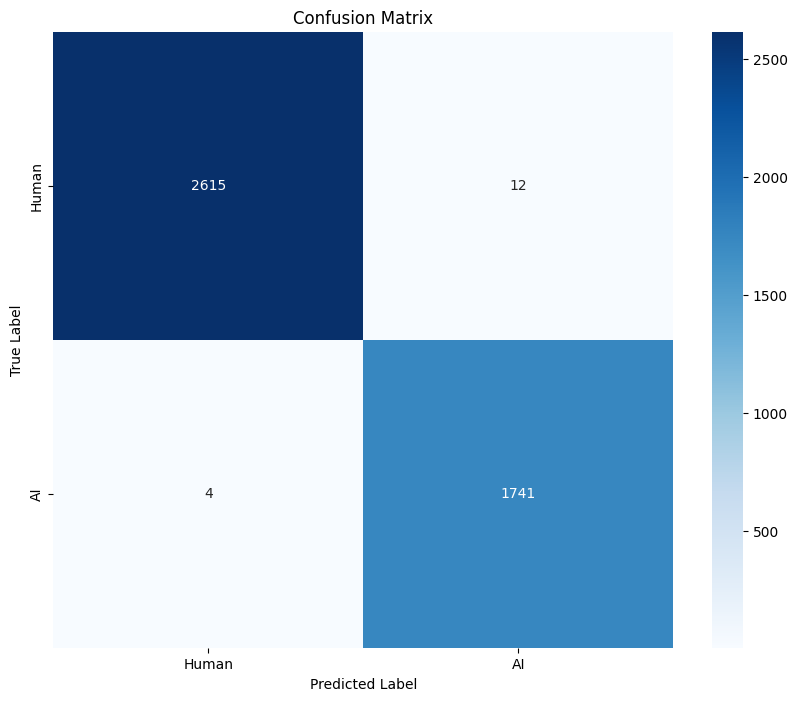

In [90]:
# Generate and display confusion matrix
class_names = ["Human", "AI"]
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.savefig(f"{save_dir}/{model_name}_confusion_matrix.png")
plt.show()

In [85]:
# Human = class 0, AI = class 1
correct_human = cm[0][0]
incorrect_human = cm[0][1]
correct_ai = cm[1][1]
incorrect_ai = cm[1][0]

results_table = pd.DataFrame({
    "Class": ["Human", "AI"],
    "Correct Predictions": [correct_human, correct_ai],
    "Misclassifications": [incorrect_human, incorrect_ai]
})

print("\nClassification Results:")
display(results_table)


Classification Results:


,Class,Correct Predictions,Misclassifications
0,Human,2615,12
1,AI,1741,4


In [87]:
!ls -la /content/drive/MyDrive/

total 10
drwx------ 3 root root 4096 Mar 26 14:55 'Colab Notebooks'
-rw------- 1 root root  176 Mar  6 14:27 'Divergence-Aware Warp Scheduling.gslides'
-rw------- 1 root root  176 Mar 18 02:46  GPUArch_midterm_slides.gslides
-rw------- 1 root root  176 Feb 25 13:55  mha_profiling.gdoc
drwx------ 3 root root 4096 Mar 28 21:06  results
-rw------- 1 root root  176 Feb 23 16:52 'Untitled document.gdoc'
